<a href="https://colab.research.google.com/github/jhk0429/Segmentation_project/blob/main/PSPNet/train_inception_psp_NewData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q git+https://github.com/tensorflow/examples.git
#!pip install -q -U tfds-nightly
!pip install segmentation_models

     |████████████████████████████████| 50 kB 6.0 MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import segmentation_models as sm

import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.6.0
Segmentation Models: using `keras` framework.


In [3]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Display One sample

(2048, 2448, 3)


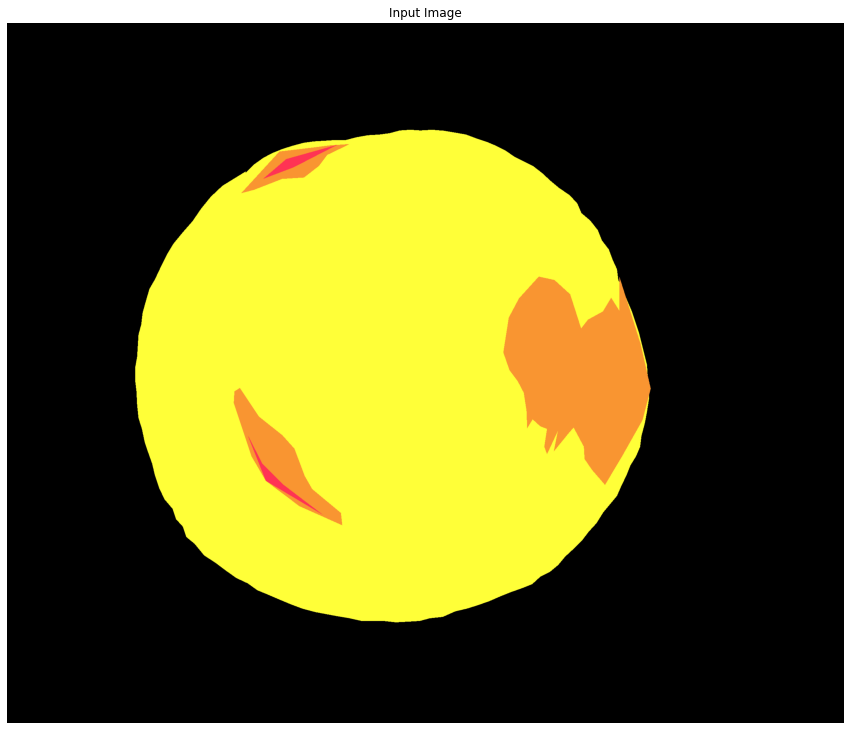

In [5]:
mask = imread('images/train/silver_ng/gt_mask/높음2__분리막 눌림_은색.png') #2048 x 2448
#image = tf.expand_dims(image, -1)
#image = tf.image.grayscale_to_rgb(image)
#mask = tf.image.resize(mask, (480,576))
print(mask.shape)
display([mask])

In [6]:
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

In [7]:
color_dict = {i: list(x) for i,x in enumerate(colors)}
print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628]}


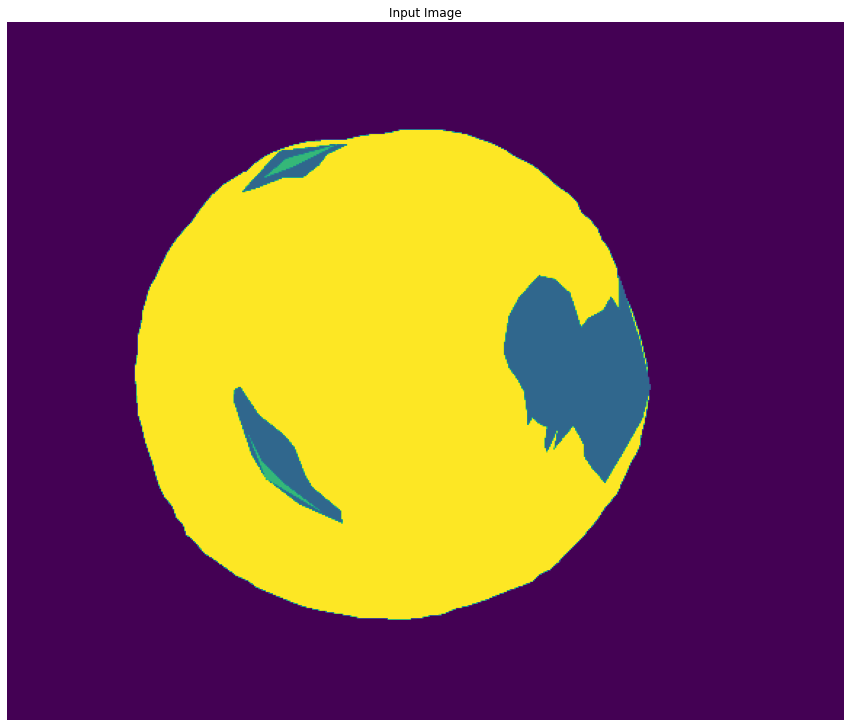

In [70]:
a = rgb_to_onehot(mask,color_dict)

bb = tf.expand_dims(np.argmax(a, axis=-1),-1)
bbb = tf.image.resize(bb, (480,576))

display([bbb])

Preprocess train images/masks:
  1. resize both
  2. for x, convert to rgb
  3. for mask, convert to one hot?
  4. for both, apply augmentation (optional)

  Note: mask in png format, img in bmp format


In [13]:
import glob
import cv2
train_x = []
train_y = []

for img in glob.glob("images/train/*/*.bmp"):
    #Image
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576))

    train_x.append(n)

    #GET FILE NAME
    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name+".png")
    #y = tf.cast(y, tf.float32) / 255.0
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576))

    train_y.append(bbb)

train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

print(train_x.shape, np.max(train_x))
print(train_y.shape, np.max(train_y))

(50, 480, 576, 3) 1.0
(50, 480, 576, 1) 3.0


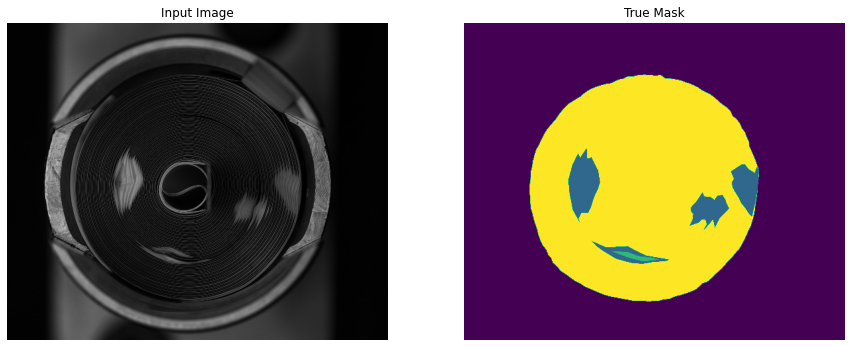

In [19]:
display([train_x[20], train_y[20] ])

In [ ]:
"""
if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
"""

'\nif tf.random.uniform(()) > 0.5:\n    input_image = tf.image.flip_left_right(input_image)\n    input_mask = tf.image.flip_left_right(input_mask)\n'

In [21]:
sample_image = train_x[20]
sample_mask = train_y[20] 

In [22]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Define Backbone model as well as segmentation model

In [23]:
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'inceptionv3'

model = sm.PSPNet(BACKBONE, input_shape=(480,576,3), classes=4, encoder_weights='imagenet', activation='softmax', encoder_freeze = True)

model.compile(
    'Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from_logits=True #loss=sm.losses.bce_jaccard_loss,
    metrics=['accuracy'],#[sm.metrics.iou_score]
)

87924736/87910968 [==============================] - 1s 0us/step


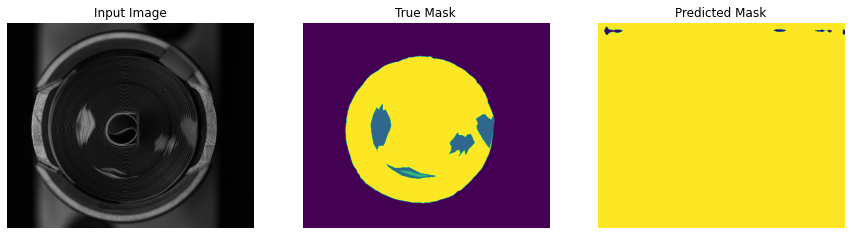

In [24]:
show_predictions()

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('{}\n에포크 이후의 예측 예시'.format(epoch+1))

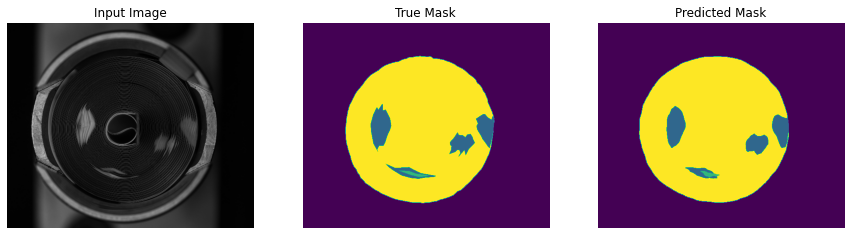

26
에포크 이후의 예측 예시


In [26]:
model_history = model.fit(x= train_x,
                          y= train_y, 
                          steps_per_epoch = 30,
                          epochs=30,
                          callbacks=[DisplayCallback()])                                

In [27]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [28]:
test_x = []
test_y = []

for img in glob.glob("images/test/*.bmp"):
    
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, (480,576))

    test_x.append(n)

    dir = "/".join(img.split("/")[:-1]) + "/gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name+".png")
    #y = tf.cast(y, tf.float32) / 255.0
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, (480,576))
    
    test_y.append(bbb)

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape)
print(test_y.shape)

(4, 480, 576, 3)
(4, 480, 576, 1)


In testing Mode...


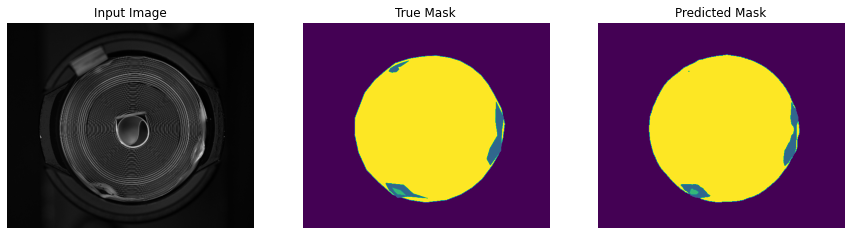

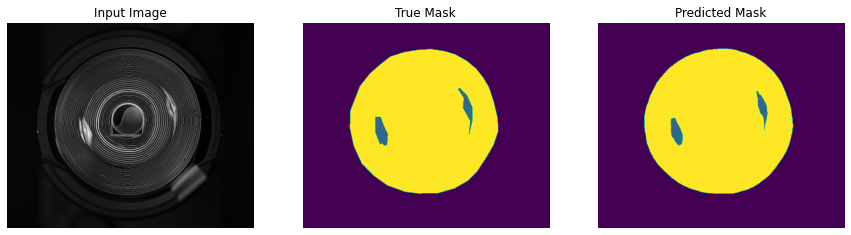

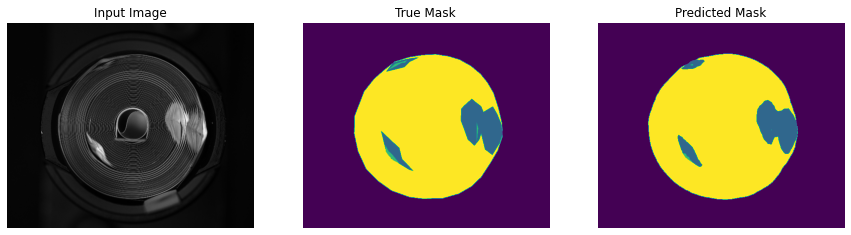

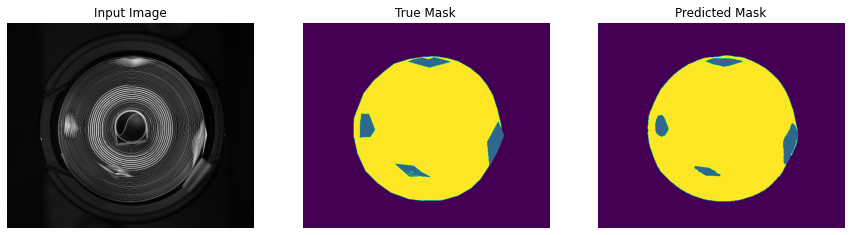

In [29]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

In [47]:
pred_mask = model.predict(test_x, batch_size=1)
aaa = create_mask(pred_mask, num=0)
dd = tf.one_hot(aaa, 4)
print(dd.shape)

(480, 576, 1, 4)


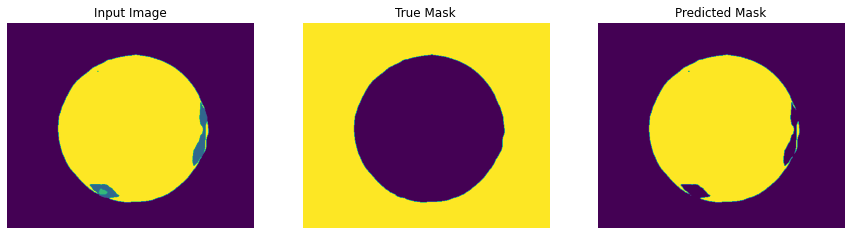

In [65]:
display([aaa, dd[:,:,:,0], dd[:,:,:,3]]) 
# 0 shows background, 1 shows "pushed", 2shows "Stamped", 3shows inner circle

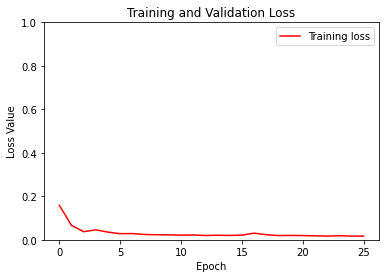

In [31]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

epochs = range(26)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

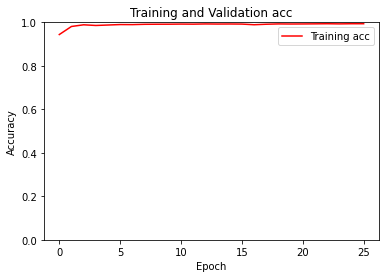

In [32]:
acc = model_history.history['accuracy']
#val_acc = model_history.history['val_accuracy']

epochs = range(26)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [33]:
print("Training accuracy at the last epoch is:", np.round(model_history.history['accuracy'][-1],3))

Training accuracy at the last epoch is: 0.994


In [66]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


Saving Model for use in Inference

In [67]:
model.save_weights('drive/MyDrive/Colab Notebooks/Inceptionv3_PSPNet_weights_newdata')
model.save('drive/MyDrive/Colab Notebooks/Inceptionv3_PSPNet_newdata')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/Inceptionv3_PSPNet_newdata/assets
